# Project code

## Data download and wrangling

### Libraries

In [127]:
library(repr)
library(tidyverse)
library(tidymodels)
library(reshape2)

### Data download

In [128]:
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00544/ObesityDataSet_raw_and_data_sinthetic%20(2).zip",temp)
obesity_data <- read.csv(unz(temp, "ObesityDataSet_raw_and_data_sinthetic.csv"))
unlink(temp)

### Wrangling data

In [129]:
obesity <- obesity_data %>%
            mutate(NObeyesdad = as_factor(NObeyesdad), CH2O = CH2O - 1) %>%
            select(Weight, FAF, CH2O, TUE, NObeyesdad)
head(obesity)

,Weight,FAF,CH2O,TUE,NObeyesdad
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,64.0,0,1,1,Normal_Weight
2,56.0,3,2,0,Normal_Weight
3,77.0,2,1,1,Normal_Weight
4,87.0,2,1,0,Overweight_Level_I
5,89.8,0,1,0,Overweight_Level_II
6,53.0,0,1,0,Normal_Weight


### Visualizing the data set

In [130]:
obesity_num <- obesity %>%
    select(Weight, FAF, CH2O, TUE) %>%
    pivot_longer(cols = Weight:TUE,
                names_to = "Variable",
                values_to = "Stat") %>%
    group_by(Variable) %>%
    summarize(Minimum = min(Stat), Maximum = max(Stat), Mean = mean(Stat), Median = median(Stat), Mode = names(table(Stat))[table(Stat)==max(table(Stat))], 
                  Standard_deviation = sd(Stat))

obesity_num

`summarise()` ungrouping output (override with `.groups` argument)



Variable,Minimum,Maximum,Mean,Median,Mode,Standard_deviation
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
CH2O,0,2,1.0080114,1.00000,1,0.6129535
FAF,0,3,1.0102977,1.00000,0,0.8505924
TUE,0,2,0.6578659,0.62535,0,0.6089273
Weight,39,173,86.5860581,83.00000,80,26.1911717


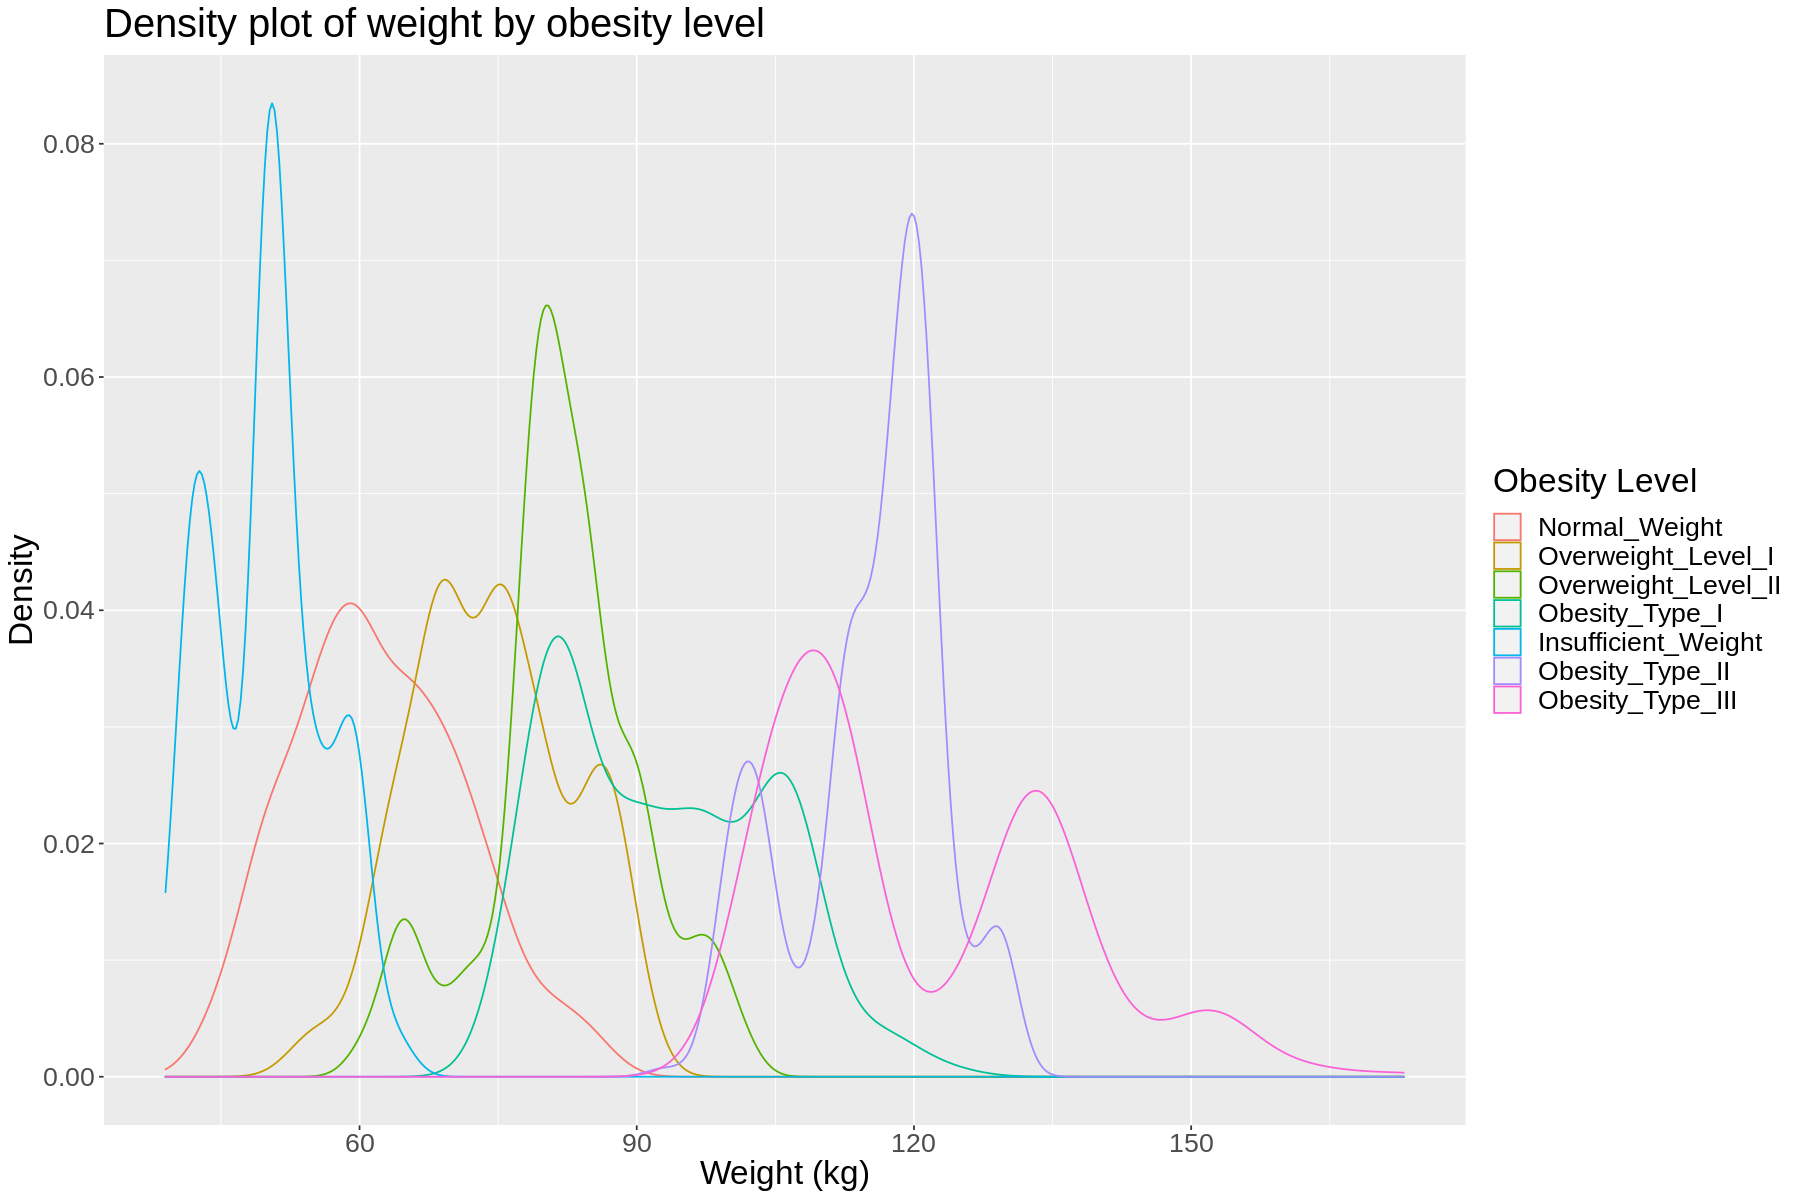

In [131]:
weight_dist <- ggplot(obesity, aes(x = Weight, colour = NObeyesdad)) +
                geom_density() +
                labs(x = "Weight (kg)", y = "Density", color = "Obesity Level", title = "Density plot of weight by obesity level") +
                theme(text = element_text(size = 20))  

options(repr.plot.length = 10, repr.plot.width = 15)

weight_dist

## Building our model

### Splitting data into training and testing data

In [132]:
set.seed(255)

obesity_split <- initial_split(obesity, prop = 0.75, strata = NObeyesdad)
obesity_test <- testing(obesity_split)
obesity_train <- training(obesity_split)

### Finding the best K to use

In [133]:
set.seed(255) 

min_vfold <- vfold_cv(obesity_train, v = 5, strata = NObeyesdad)

min_spec <- nearest_neighbor(weight_fun = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

obesity_recipe <- recipe(NObeyesdad ~ Weight + FAF + CH2O + TUE, data = obesity_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())  
 

k_data <- workflow() %>%
        add_recipe(obesity_recipe) %>%
        add_model(min_spec) %>%
        tune_grid(resamples = min_vfold, grid = 10) %>%
        collect_metrics() %>%
        filter(.metric == "accuracy") %>%
        arrange(desc(mean))

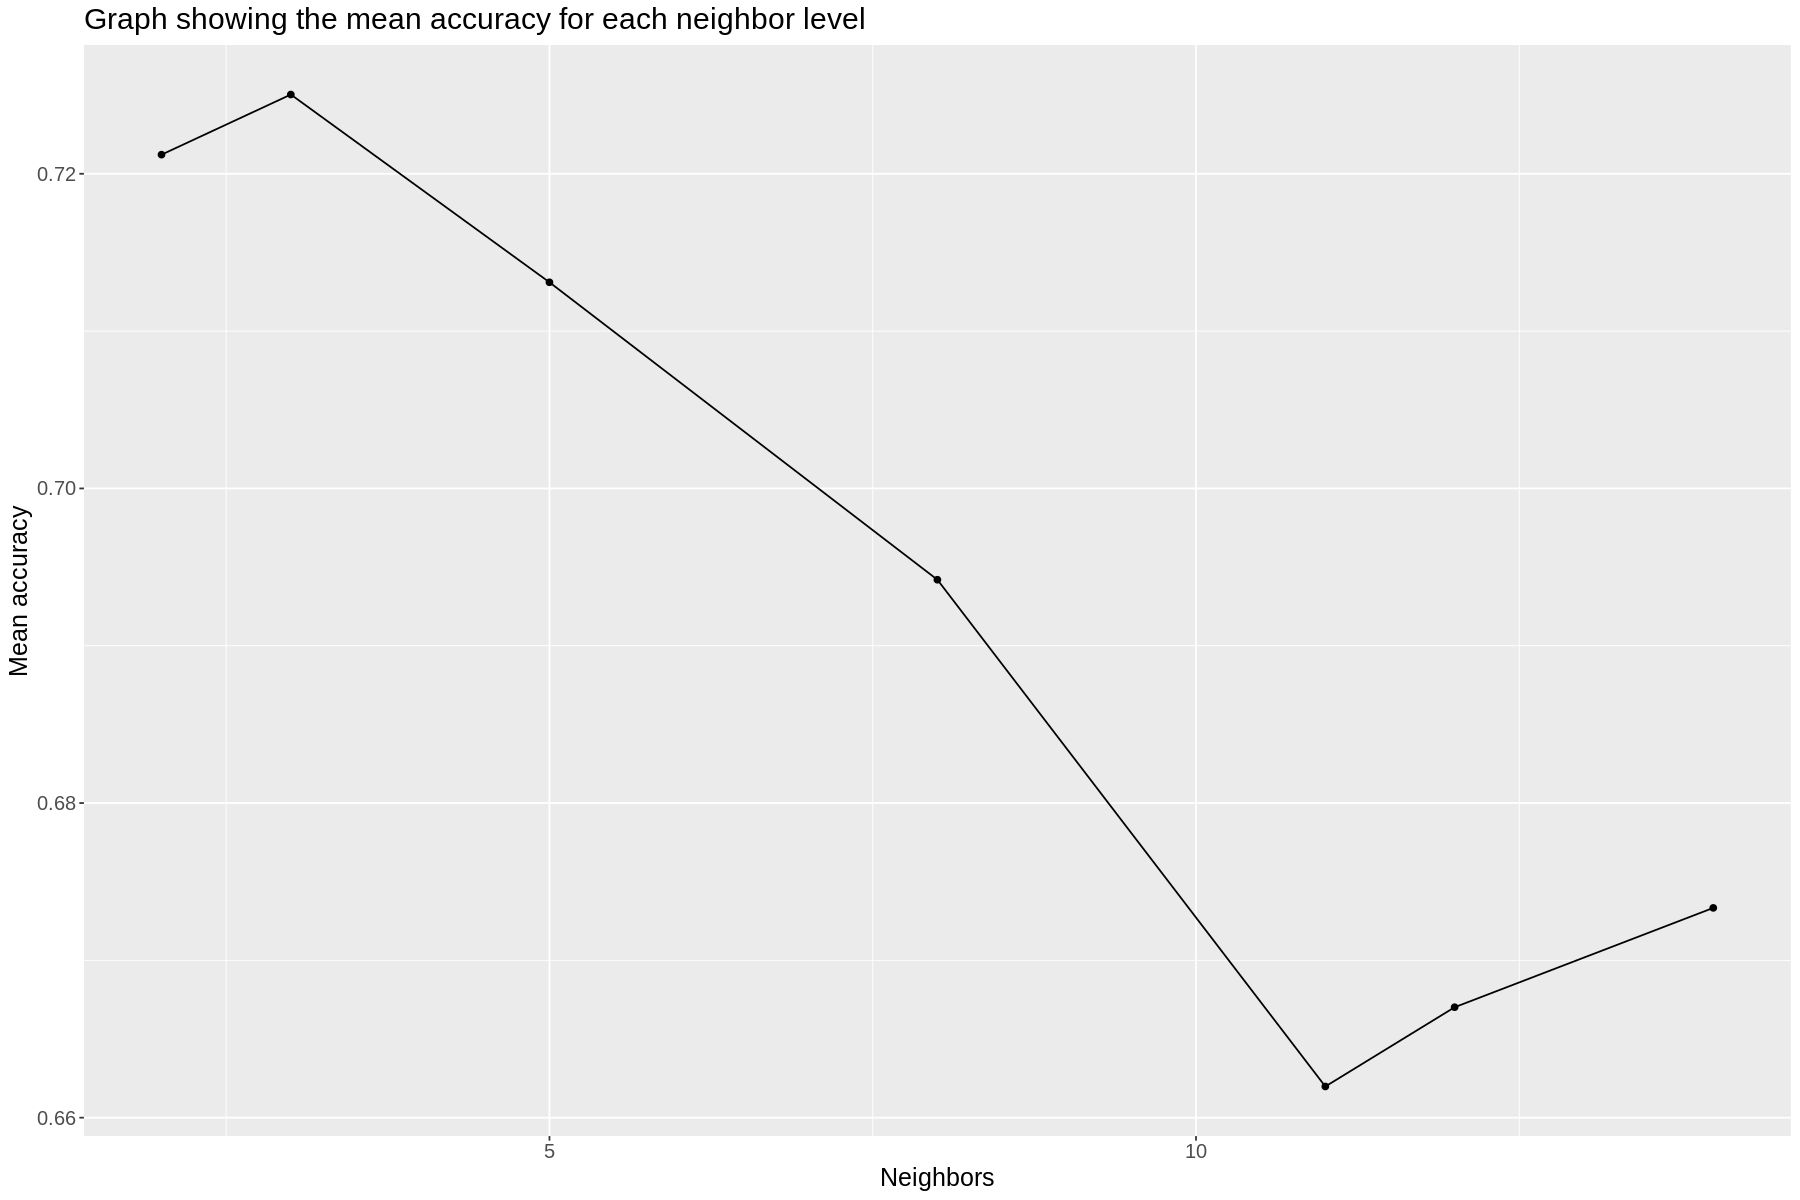

In [134]:
k_plot <- ggplot(k_data, aes(x = neighbors, y = mean)) +
            geom_line() +
            geom_point() +
            labs(x = "Neighbors", y = "Mean accuracy", title = "Graph showing the mean accuracy for each neighbor level") +
            theme(text = element_text(size = 15))

k_plot

k_min <- k_data %>%
            slice(1) %>%
            pull(neighbors)

In [135]:
k_data

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,multiclass,0.7250381,5,0.009513635,Model2
2,accuracy,multiclass,0.7212164,5,0.008922966,Model1
5,accuracy,multiclass,0.7131022,5,0.007478072,Model3
8,accuracy,multiclass,0.6941952,5,0.006455523,Model4
14,accuracy,multiclass,0.6733351,5,0.005904148,Model7
12,accuracy,multiclass,0.6670215,5,0.004513911,Model6
11,accuracy,multiclass,0.6619818,5,0.004191298,Model5


### Using our K to create the model

In [136]:
set.seed(255)

obesity_vfold <- vfold_cv(obesity_train, v = 5, strata = NObeyesdad)

obesity_spec <- nearest_neighbor(weight_fun = "rectangular", neighbors = k_min) %>%
                set_engine("kknn") %>%
                set_mode("classification")


obesity_fit <- workflow() %>%
        add_recipe(obesity_recipe) %>%
        add_model(obesity_spec) %>%
        fit(obesity)

## Testing the model

In [137]:
set.seed(255)
predictions <- predict(obesity_fit, obesity_test) %>%
                bind_cols(obesity_test)

head(predictions)

obesity_metrics <- predictions %>%
                metrics(truth = NObeyesdad, estimate = .pred_class)

obesity_conf_mat <- predictions %>%
                conf_mat(truth = NObeyesdad, estimate = .pred_class)


obesity_metrics

obesity_conf_mat

.pred_class,Weight,FAF,CH2O,TUE,NObeyesdad
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Overweight_Level_I,87,2,1,0,Overweight_Level_I
Normal_Weight,53,3,1,0,Normal_Weight
Overweight_Level_II,80,2,1,1,Overweight_Level_II
Obesity_Type_II,102,1,0,0,Overweight_Level_II
Overweight_Level_I,70,0,1,0,Overweight_Level_I
Normal_Weight,60,1,1,0,Normal_Weight


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8933333
kap,multiclass,0.8754179


                     Truth
Prediction            Normal_Weight Overweight_Level_I Overweight_Level_II
  Normal_Weight                  63                  4                   5
  Overweight_Level_I              2                 59                   2
  Overweight_Level_II             2                  7                  54
  Obesity_Type_I                  0                  2                   7
  Insufficient_Weight             4                  0                   3
  Obesity_Type_II                 0                  0                   1
  Obesity_Type_III                0                  0                   0
                     Truth
Prediction            Obesity_Type_I Insufficient_Weight Obesity_Type_II
  Normal_Weight                    0                   4               0
  Overweight_Level_I               1                   0               0
  Overweight_Level_II              8                   0               1
  Obesity_Type_I                  77                  

### Prediction

In [138]:
set.seed(255)
new_obs <- tibble(Weight = runif(1,60,100), FAF = runif(1,0,3), CH2O = runif(1,0,2), TUE = runif(1,0,3), NObeyesdad = "Unknown")

obesity_new <- rbind(obesity, new_obs)

new_pred <- predict(obesity_fit, new_obs) %>%
                    bind_cols(new_obs) %>%
                    rename(Prediction = .pred_class) %>%
                    select(-"NObeyesdad") %>%
                    relocate(Prediction, .after = TUE)

new_pred

Weight,FAF,CH2O,TUE,Prediction
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
80.9716,1.708775,1.08269,1.419376,Overweight_Level_II


## Visualization of the analysis

In [140]:
options(repr.plot.width = 20, repr.plot.length = 20)
names <- c("Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Insufficient_Weight ","Obesity_Type_II", "Obesity_Type_III")

matrix_df <- matrix(unlist(obesity_conf_mat), ncol = 7, nrow = 7) %>%
            round((matrix/colSums(matrix))*100,2) %>%
            as.data.frame()

colnames(matrix_df)  <- names

matrix_df_2 <-  matrix_df %>%
                mutate(Prediction = names) %>%
                relocate(Prediction, .before = Normal_Weight) %>%
                melt()


matrix_df_2$Prediction <- factor(matrix_df_2$Prediction,levels=names)
matrix_df_2$variable <- factor(matrix_df_2$variable, levels=names)

matrix_heatmap <- ggplot(matrix_df_2, aes(x = variable, y = Prediction, fill = value)) +
                    geom_tile() +
                    geom_text(aes(label = value), color = "white", size = 6) +
                    labs(x = "Truth", y = "Prediction", fill = "Prediction accuracy per class", title = "Heatmap of the confusion matrix") +
                    theme(text = element_text(size = 18))
                    
matrix_heatmap

ERROR: Error in function_list[[i]](value): 3 arguments passed to 'round'which requires 1 or 2 arguments
